In [2]:
%matplotlib inline

import sys
sys.path.append('/home/alexgonzalez/Documents/TreeMazeAnalyses/PreProcessing/')

from pathlib import Path
import h5py
import json
import nept
import numpy as np
import pandas as pd
from dataConvert import getInt16ConvFactor, data2int16
from robust_stats import *
from scipy import signal
from scipy import stats
from pre_process_neuralynx import *

from fooof import FOOOF
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
plt.rc('text', usetex=True)

In [3]:
def getSessionInfo(session):
    return session.split('_')

def getTT_Info(dataDir,ttNum):
        
    nChans = 4
    ADs = np.zeros(nChans)
    RefChan = np.zeros(nChans)
    ChanIDs = np.zeros(nChans)
    InputRange = np.zeros(nChans) 

    # get headers:
    chanFiles = ['CSC{}{}.ncs'.format(ttNum,ch) for ch in ['a','b','c','d']]
    try:
        headers = []
        for ch, chf in enumerate(chanFiles):
            headers.append(get_header(str(dataDir/chf)))
    except:
        print('Header Files could not be loaded. Error reading files from')
    
    fs = headers[0]['fs']
    for ch, header in enumerate(headers):
        ADs[ch] = header['AD']
        RefChan[ch] = header['RefChan']
        ChanIDs[ch] = header['ChanID']
        InputRange[ch] = header['InputRange']
    
    return  {'dataDir': str(dataDir), 'session': dataDir.name, 'fs':fs,'TT':ttNum, 'nChans': 4, 'chanFiles':chanFiles, 'ADs': ADs, 'RefChan':RefChan, 'ChanIDs':ChanIDs, 'InputRange':InputRange}
    

In [4]:
# directory for some data
dataRoot = '/Data_SSD2T/Data'
subject = 'Li'
task = 'T3g'
date = '062518'
tt = 7
session = '{}_{}_{}'.format(subject,task,date)
dataDir = Path(dataRoot,subject,session)
ttInfo = getTT_Info(dataDir, tt)

In [5]:
ttInfo

{'dataDir': '/Data_SSD2T/Data/Li/Li_T3g_062518',
 'session': 'Li_T3g_062518',
 'fs': 32000,
 'TT': 7,
 'nChans': 4,
 'chanFiles': ['CSC7a.ncs', 'CSC7b.ncs', 'CSC7c.ncs', 'CSC7d.ncs'],
 'ADs': array([6.10351563e-08, 6.10351563e-08, 6.10351563e-08, 6.10351563e-08]),
 'RefChan': array([19., 19., 19., 19.]),
 'ChanIDs': array([24., 25., 26., 27.]),
 'InputRange': array([2000., 2000., 2000., 2000.])}

In [8]:
# pre-allocate data
fs = ttInfo['fs']
nChans = len(ttInfo['chanFiles'])
sig, time = get_csc(str(dataDir/ttInfo['chanFiles'][0]))
nSamps = len(sig)
rawSignals = np.empty((nChans,nSamps))
rawSignals[0] = sig

for i, ch in enumerate(ttInfo['chanFiles'][1:]):
    rawSignals[i+1], _  = get_csc(str(dataDir/ch))


In [383]:
def getAmpHist(signals,ttInfo, binStep=50):
    nChans = ttInfo['nChans']
    
    maxAmp = max(ttInfo['InputRange'])
    bins = np.arange(-maxAmp,maxAmp+1,binStep)
    binCenters = bins[:-1]+binStep/2

    ampHist = np.zeros((nChans,len(binCenters)))
    
    for ch in range(nChans):
        ampHist[ch],_ = np.histogram(signals[ch],bins)
        
    return ampHist, binCenters

hists,bins=getAmpHist(rawSignals,ttInfo)
ttInfo['rawAmpHists'] = hists
ttInfo['HistBins'] = bins

In [ ]:
ttInfo

/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


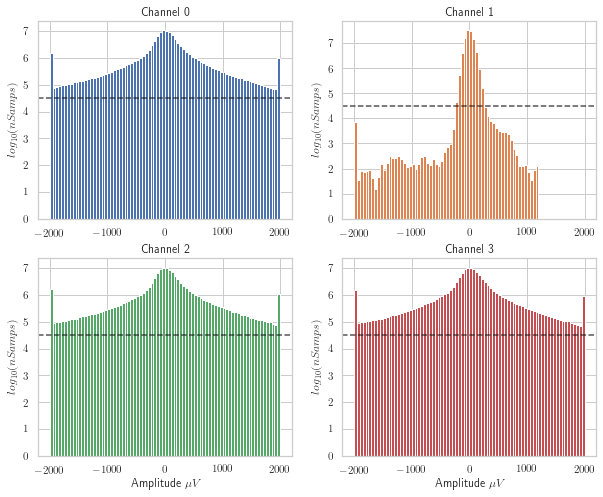

In [101]:
def plotAmpHist(hist, bins,ax=None,**kwags):
    if ax is None:
        fig,ax = plt.subplots()
        ax = ax.flatten()
    else:
        ax.bar(bins,np.log10(hist), width=(bins[1]-bins[0]),**kwags)
    
    ax.set_xlabel(r'Amplitude $\mu V$')
    ax.set_ylabel(r'$log_{10}(nSamps)$')
    
    return ax

def plotTTAmpsHists(hists,binCenters,ttInfo,ax=None):
    nChans=ttInfo['nChans']
    xlim = np.max(ttInfo['InputRange'])*1.1
    fs = ttInfo['fs']
    if ax is None:
        fig,ax = plt.subplots(2,2, figsize=(10,8))
        ax = ax.flatten()
        axFlag = 0
    elif len(ax)!= nChans:
        print('Warning. # of signals mismatch # of given axes to plot historgrams, creating new figure.')
        fig,ax = plt.subplots((2,2), figsize=(10,8))
        ax = ax.flatten()
        axFlag = 0
    else:
        axFlag = 1
    prop_cycle = plt.rcParams['axes.prop_cycle']
    cl = prop_cycle.by_key()['color']
    for ch in range(nChans):
        ax[ch] = plotAmpHist(hists[ch],binCenters,ax=ax[ch],color=cl[ch])
        ax[ch].set_title('Channel {}'.format(ch))
        if axFlag==0:
            if ch<2:
                ax[ch].set_xlabel('')
        ax[ch].set_xlim(-xlim,xlim)
        ax[ch].axhline(np.log10(fs),color='k', linestyle = '--', alpha=0.75)
        ax[ch].
    return ax
_=plotTTAmpsHists(hists,bins,ttInfo)

In [9]:
def getChansPSD(sigs,fs, resamp=True):
    # find next power of 2 based on fs: e
    # for fs=32k, nperseg = 2**15 = 32768, 
    # the operation belows computes this efficiently for aribitary fs
    
    # assumes that sigs is nChans x nSamps
    
    if np.argmax(sigs.shape)==0:
        sigs = sigs.T
        transposeFlag = 1
    else:
        transposeFlag = 0
    
    fs = int(fs)
    nperseg = (1<<(fs-1).bit_length()) 
    noverlap = 1<<int(fs*0.05-1).bit_length()  # for at least 5% overlap.
    freqs,pxx = signal.welch(sigs,fs =fs, nperseg=nperseg, noverlap=noverlap)
    
    if resamp:
        # resample log-linear
        samps = np.arange(100)

        maxExp = 4
        for e in np.arange(2,maxExp):
            samps = np.concatenate( (samps, np.arange(10**e,10**(e+1),10**(e-1)) ) )

        
        freqs = freqs[samps]
        if sigs.ndim==1:
            pxx = pxx[samps]
        else:
            pxx = pxx[:,samps]
    
        if transposeFlag:
            pxx = pxx.T
    
    return pxx,freqs

pxx,freqs=getChansPSD(rawSignals,ttInfo['fs'],resamp=True)

In [390]:
ttInfo['rawPSD'] = pxx
ttInfo['PSDFreqs'] = freqs

In [402]:
ttInfo

{'dataDir': '/Data_SSD2T/Data/Li/Li_T3g_062518',
 'session': 'Li_T3g_062518',
 'fs': 32000,
 'TT': 7,
 'nChans': 4,
 'chanFiles': ['CSC7a.ncs', 'CSC7b.ncs', 'CSC7c.ncs', 'CSC7d.ncs'],
 'ADs': array([6.10351563e-08, 6.10351563e-08, 6.10351563e-08, 6.10351563e-08]),
 'RefChan': array([19., 19., 19., 19.]),
 'ChanIDs': array([24., 25., 26., 27.]),
 'InputRange': array([2000., 2000., 2000., 2000.]),
 'rawAmpHists': array([[1.5771080e+06, 7.6713000e+04, 8.1395000e+04, 8.8022000e+04,
         9.5663000e+04, 1.0079600e+05, 1.0320900e+05, 1.0807400e+05,
         1.2283400e+05, 1.3105500e+05, 1.3528100e+05, 1.4406300e+05,
         1.5050600e+05, 1.6216400e+05, 1.7601000e+05, 1.8221000e+05,
         1.9556800e+05, 2.2127100e+05, 2.3996900e+05, 2.5947000e+05,
         2.8741900e+05, 3.0352300e+05, 3.4428600e+05, 3.8670000e+05,
         4.1941900e+05, 4.6404800e+05, 5.2755600e+05, 6.0397000e+05,
         6.7788800e+05, 7.4673800e+05, 8.7155600e+05, 1.0165230e+06,
         1.2305790e+06, 1.5211660e

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d2c957c18>,
      dtype=object)

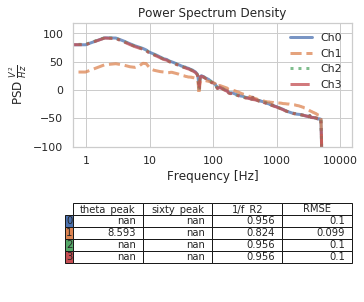

In [336]:
def plotTT_PSD(freqs,pxx,ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(5,4))

    ls = ['-', '--', ':', '-.']
    nChans = pxx.shape[0]
    for ch in range(nChans):
        ax.semilogx(freqs,20*np.log10(pxx[ch]), alpha=0.75, linestyle=ls[ch], linewidth=3)
    ax.legend(['Ch{}'.format(ch) for ch in range(nChans)], frameon=False)
    ax.set_xticks([1,10,100,1000,10000])
    ax.set_xticklabels([1,10,100,1000,10000])

    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(r"PSD $\frac{V^2}{Hz}$")
    ax.set_ylim(-100,ax.get_ylim()[1])
    ax.set_title('Power Spectrum Density')
    return ax
def getTT_PSDpeaks(freqs,pxx):
    nChans = pxx.shape[0]
    
    df = pd.DataFrame(columns=['theta_peak','sixty_peak','1/f_R2','RMSE'])
    for ch in range(nChans):
        fm = FOOOF( max_n_peaks=2, peak_threshold=2.0, peak_width_limits=[0.5,6.0], verbose=False)
        fm.fit(freqs,pxx[ch],[2,100])
        
        pks = fm.peak_params_.flatten()[::3]
        
        
        thetaPk = pks[(pks>=5) & (pks<=12)]
        sixtyPk = pks[(pks>=58) & (pks<=62)]
        
        if len(thetaPk)==1:
            df.at[ch,'theta_peak'] = np.around(thetaPk[0],decimals=3)
        elif len(thetaPk)>1:
            df.at[ch,'theta_peak'] = np.around(np.mean(thetaPk),decimals=3)
        
        if len(sixtyPk)==1:
            df.at[ch,'sixty_peak'] = np.around(sixtyPk[0],decimals=3)
        elif len(sixtyPk)>1:
            df.at[ch,'sixty_peak'] = np.around(np.mean(sixtyPk),decimals=3)
            
        df.at[ch,'RMSE'] = np.around(fm.error_,decimals=3)
        df.at[ch,'1/f_R2'] = np.around(fm.r_squared_,decimals=3)
    return df

def plotTT_PSD_Table(freqs,pxx, df, ax=None):
    if ax is None:
        f,ax = plt.subplots(2,1,figsize=(5,5))

    ax[0] = plotTT_PSD(freqs,pxx,ax=ax[0])

    ax[1].axis('off')
    prop_cycle = plt.rcParams['axes.prop_cycle']
    cl = prop_cycle.by_key()['color']
    pd.plotting.table(ax[1], df.round(2), loc='center', fontsize=20,rowColours=cl)

    return ax
plt.rc('text', usetex=False)
df = getTT_PSDpeaks(freqs,pxx)

plotTT_PSD_Table(freqs,pxx, df)

In [13]:
ch=0
fm = FOOOF( max_n_peaks=2, peak_threshold=2.0, peak_width_limits=[0.5,6.0], verbose=False)
fm.fit(freqs,pxx[ch],[2,100])

pks = fm.peak_params_.flatten()[::3]
print(pks)

[45.99253227 59.76816788]


In [16]:
fm.peak_params_.flatten()[1::3]

array([0.2391228 , 0.21492026])

#### Raw Data Summary

/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


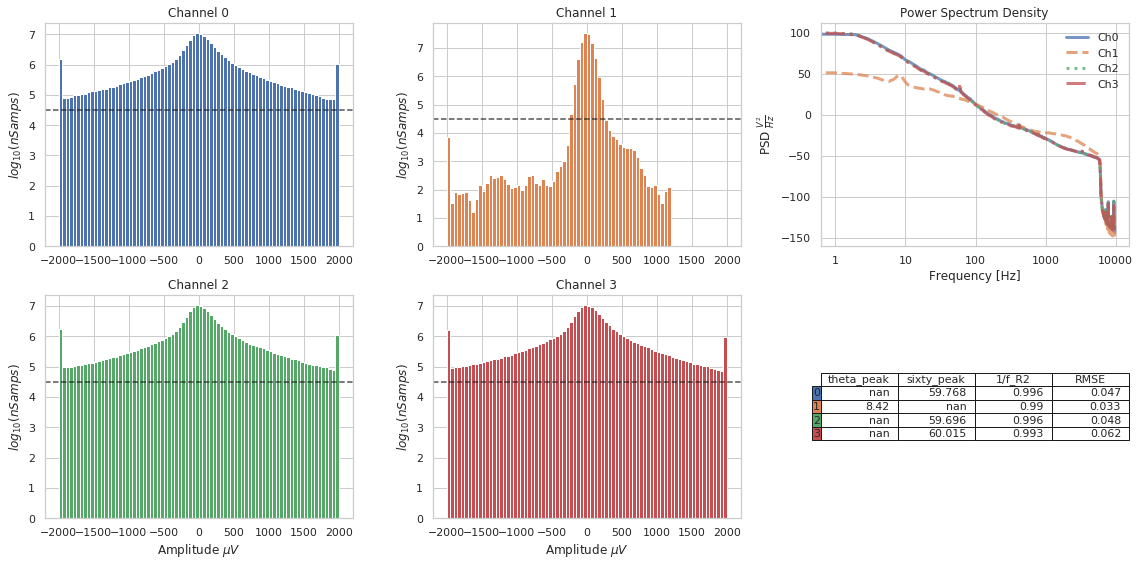

In [200]:
fig,ax = plt.subplots(2,3, figsize=(16,8))
ax= ax.flatten()
_=plotTTAmpsHists(hists,bins,ttInfo,ax[[0,1,3,4]])
ax[0].set_xlabel('')
ax[1].set_xlabel('')
_=plotTT_PSD_Table(freqs,pxx, df,ax[[2,5]])
fig.tight_layout(pad=1.0)

In [205]:
def getClippedSegments(signals,ttInfo,thr=0.99,segBuffer=0.5):
    """
    function that takes signals and return segments of clipped signal buffered by fs*segBuffer. 
    
    Inputs: 
        signals -> nChans x nSamps np.array
        ttInfo -> dict, must contain nChans, fs, and InputRange (maxAmplitude)
        thr -> float, thr*InputRange is used threshold the signal
        segBuffer -> float, seconds to buffer the clipped signal, segments take the buffer into account
        
    Returns:
        Segs -> list of length nChans, each is a np.array of clipped segments for that channel (start and end indexes by # segments) in samples
        Durs -> list of length nChans, each element of the list is a np.array of length nSegs for that channel containing the durations in samples
    """
    
    nChans = ttInfo['nChans']
    fs = ttInfo['fs']
    
    # binarize clipped segments
    segBuffer = int(np.floor(fs*0.5))
    
    Durs = []
    Segs = []
    for ch in range(nChans):
        signalMask = (np.abs(signals[ch])>=ttInfo['InputRange'][ch]*thr).astype(int)
        diffSig = np.concatenate( ([0],np.diff(signalMask)) )
        idxStart = np.argwhere(diffSig>0).flatten()
        idxEnd = np.argwhere(diffSig<0).flatten()

        # if idxStart and end match (ends>starts, #ends==#starts)
        if len(idxStart)==len(idxEnd):
            if all(idxEnd>idxStart): 
                pass
            else: # if some reason some starts > ends..
                print('Some start/end masking indices mismatch for ch{}'.format(ch))
                break #channel loop

        # edge case of clipping near the end of the recording
        elif (len(idxEnd)+1)==len(idxStart): 
            if np.all(idxEnd>idxStart[:-1]):
                idxEnd = np.concatenate((idxEnd,np.array([fs])))
            else:
                print('start/end masking indices mismatch for ch{}'.format(ch))
                break #channel loop
        else:
            print('unkown error in masks for ch{}, debug independently.'.format(ch))
            break #channel loop

        # add a full second of buffering time for all segments
        idxStart = idxStart-segBuffer
        idxEnd = idxEnd+segBuffer

        # deal with start and end of recording
        ii = 0
        while True:
            if idxStart[ii]-segBuffer<0:
                idxStart[ii]=0
            else:
                break #while
            ii+=1

        ii = 1
        while True:
            if idxEnd[-ii]+segBuffer>nSamps:
                idxEnd[-ii]=nSamps
            else:
                break #while
            ii+=1

        # consolidate segments after the buffering
        cnt = 0 
        SegCnt = 0
        nSubSegs = len(idxStart)
        segs = []
        segs.append((idxStart[0],idxEnd[0]))

        # check if start of the next sub segment is inside the previous, and converge if so
        while cnt<(nSubSegs-1):
            while cnt< (nSubSegs-1):
                if idxStart[cnt+1]<=idxEnd[cnt]:
                    segs[SegCnt]=(segs[SegCnt][0],idxEnd[cnt+1])
                    cnt+=1
                else:
                    cnt+=1
                    break

            segs.append((idxStart[cnt],idxEnd[cnt]))
            SegCnt+=1
        durs = np.array(([j-i for i,j in segs]))
        segs = np.array(segs)

        Durs.append(durs)
        Segs.append(segs)
    return Segs, Durs

def createChanMasks(Segs,signals):
    masks = np.zeros_like(signals,dtype=bool)
    nChans = signals.shape[0]
    for ch in range(nChans):
        for seg in Segs[ch]:
            masks[ch][seg[0]:seg[1]]=True
    return masks

Segs,Durs = getClippedSegments(rawSignals,ttInfo)

In [398]:
ttInfo['RawClippedSegs'] = Segs
ttInfo['RawClippedDurs'] = Durs
ttInfo['PctChanClipped'] = [np.sum(d)/nSamps for d in Durs]

In [218]:


masks = createChanMasks(Segs,rawSignals)

In [220]:
ch=1
rawSignals[ch][masks[ch]]

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

[0.2521645969404767,
 0.000683709154052477,
 0.24474334062112318,
 0.2302074196780133]

In [217]:
[np.sum(durs)/nSamps for durs in Durs]

[0.2521645969404767,
 0.000683709154052477,
 0.24474334062112318,
 0.2302074196780133]

In [321]:

def getSOS_FilterBank(fTypes,fs=32000.0, HP_EdgeFreq=None, LP_EdgeFreq=None, Sp_EdgeFreq = None, Notch_Freq=None, Notch_Harmonics=2, Notch_Q=20, gpass = 0.2, gstop=60.0, zi = False):
    """
    Function that creates default filters
    fTypes -> list of filters that have to be ['HP', 'LP', 'Notch', 'Sp']. 
    fs -> integer, sampling frequency in samps/s defualt to 32000
    *_EdgeFreq -> edge frequencies for each filter type. 
        Defaults are: HP-2Hz, LP-5000Hz, Sp->300Hz [High Pass], Notch->60Hz (3 Harmonics) 
    Notch_Harmonics -> int, # of harmonics from Notch_Freq to filter [as default]
    gpass -> allowed oscillation gain in the pass bands [def. 0.2dB ~ to up to 1.03 multiplication of the pass band  ]
    gstop -> required suppresion in the stopband [def. 60dB ~ at least to 0.001 multiplication of the stop band  - ]
    returns SOS a N sections x 6 second order sections filter matrix.
    """
    
    SOS = np.zeros((0,6))
    for f in fTypes:
        if f not in ['HP', 'LP', 'Notch', 'Sp']:
            print('ftype {} not supported.'.format(f))
            print('skipping filter.')
        
        # settings for low pass and bandpass
        if f in ['LP','HP']:
            
            if f is 'LP':
                if LP_EdgeFreq is None:
                    cutFreq = 5000.0
                    cutBuffer = 5500.0
                elif LP_EdgeFreq<fs/2:
                    cutFreq = LP_EdgeFreq
                    cutBuffer = LP_EdgeFreq+LP_EdgeFreq*0.1
                else:
                    print('Requested Low Pass Frequency {} is greater than the Nyquist {} frequency. Skipping filter.'.format(LP_EdgeFreq,fs))
                    
            elif f is 'HP':
                if HP_EdgeFreq is None:
                    cutFreq = 2.0
                    cutBuffer = 0.2
                else:
                    cutFreq = HP_EdgeFreq
                    cutBuffer = HP_EdgeFreq*0.1

            sos = signal.iirdesign(cutFreq/(fs/2), cutBuffer/(fs/2), gpass, gstop, output='sos')
            SOS = np.vstack((SOS,sos))
            
        if f is 'Notch':
            
            nNotches = Notch_Harmonics+1
            
            if Notch_Freq is None:
                cutFreq = np.arange(1, nNotches+1)*60.0
            else:
                cutFreq = np.arange(1, nNotches+1)*Notch_Freq
                           
            if Notch_Q is None:
                Q = np.array(cutFreq) # changing Quality factor to keep notch bandwidth constant.
                
            elif type(Notch_Q) is np.ndarray:
                if len(Notch_Q)>=nNotches:
                    Q = np.array(Notch_Q)
                # if length of quality factor array don't match the number of harmonics default to the first one
                elif len(Notch_Q)<nNotches: 
                    Q = np.ones(nNotches)*Notch_Q[0]
            else:
                    #Q = np.ones(nNotches)*Notch_Q
                    Q =  np.arange(1, nNotches+1)*Notch_Q
            
            for i, notch in enumerate(cutFreq):
                b,a = signal.iirnotch(notch,Q[i], fs=fs)
                sos = signal.tf2sos(b,a)
                SOS = np.vstack((SOS,sos))

        if f is 'Sp':
            if Sp_EdgeFreq is None:
                cutFreq = 350.0
                cutBuffer = 300.0
            else:
                cutFreq = Sp_EdgeFreq
                cutBuffer = Sp_EdgeFreq-Sp_EdgeFreq*0.1
            sos = signal.iirdesign(cutFreq/(fs/2), cutBuffer/(fs/2), gpass, gstop, output='sos')
            SOS = np.vstack((SOS,sos))
    
    zi = signal.sosfilt_zi(SOS)
    return SOS, zi

def plotFreqResponse(w,h,fs, ax=None):
    if ax==None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    
    
    ax.set_title('Digital filter frequency response')
    ax.semilogx(w/np.pi*(fs/2), 20 * np.log10(abs(h)), 'b')
    ax.set_ylabel('Amplitude [dB]', color='b')
    ax.set_xlabel('Frequency Hz')
    ax.set_ylim([-120, 20])
    ax.set_xlim([0.1, fs/2])
    

    return fig, ax


SOS,_ = getSOS_FilterBank(['HP','LP','Notch'])
    

/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log10


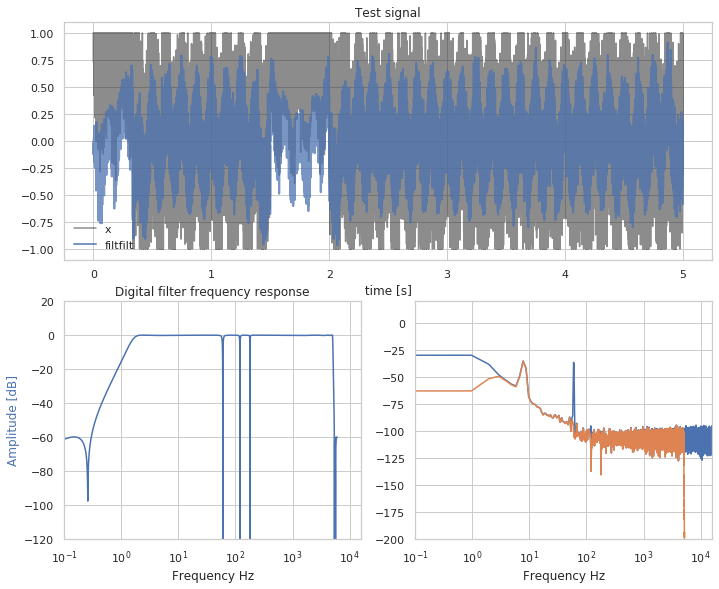

In [382]:
SOS, _ = getSOS_FilterBank(['LP','HP','Notch'], fs=fs)
    
def plotTestSOSFilter(SOS,fs, cos_f = [60,8], cos_a = [0.2, 0.25], noise = [0.1]):
    
    nSamps = int(fs*5)
    t = np.arange(nSamps)/fs
    
    x = (np.arange(nSamps) < fs/3) + ((np.arange(nSamps)>1.5*fs) & (np.arange(nSamps)<2*fs)) 
    for ii in range(len(cos_f)):
        x = x + cos_a[ii]*np.cos(2*np.pi*cos_f[ii]*t)
        
    for jj in range(len(noise)):
        x = x + np.random.randn(nSamps)*noise[jj]
     
    x[x>=1]=1
    x[x<=-1]=-1
    
    xf = signal.sosfiltfilt(SOS, x)
    
    fig = plt.figure(figsize=(10,8))
    ax1 = plt.subplot2grid((2,2),(0,0),colspan=2)
    ax2 = plt.subplot2grid((2,2),(1,0))
    ax3 = plt.subplot2grid((2,2),(1,1))
    fig.tight_layout(pad=1.5)

    w,h = signal.sosfreqz(SOS,worN=np.concatenate((np.arange(0,200,1/2**8),np.arange(200,6000,1/2**8))),fs=fs)
    _ = plotFreqResponse(w/fs*(2*np.pi),h,fs,ax=ax2)
   
    

    ax1.plot(t,x, 'k-',label='x',alpha=0.5)
    ax1.plot(t,xf,  alpha=0.75, linewidth=2, label='filtfilt')
    ax1.legend(loc='best',frameon=False)
    ax1.set_title('Test signal')
    ax1.set_xlabel(' time [s] ')


    pxx,freqs=getChansPSD(x,fs,resamp=False)
    ax3.semilogx(freqs,20*np.log10(pxx))
    pxx,freqs=getChansPSD(xf,fs,resamp=False)
    ax3.semilogx(freqs,20*np.log10(pxx))
    ax3.set_xlim([0.1,fs/2])
    ax3.set_ylim([-200,20])
    ax3.set_xlabel('Frequency Hz')
    
    
testSOSFilter(SOS,fs , cos_f = [60,8], cos_a = [0.25, 0.25],noise=[0.3])


### filter signals

In [329]:
SOS, _ = getSOS_FilterBank(['LP','HP','Notch'], fs=fs)

fsignals = np.zeros_like(rawSignals)
for ch in range(nChans):
    fsignals[ch] = signal.sosfiltfilt(SOS, rawSignals[ch])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d27e06cf8>,
      dtype=object)

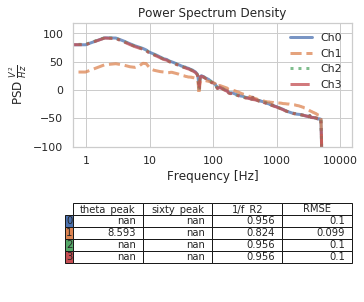

In [337]:
pxx,freqs=getChansPSD(fsignals,ttInfo['fs'],resamp=True)
hists,bins=getAmpHist(fsignals,ttInfo)
df = getTT_PSDpeaks(freqs,pxx)
#plotTT_PSD_Table(freqs,pxx, df)


/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


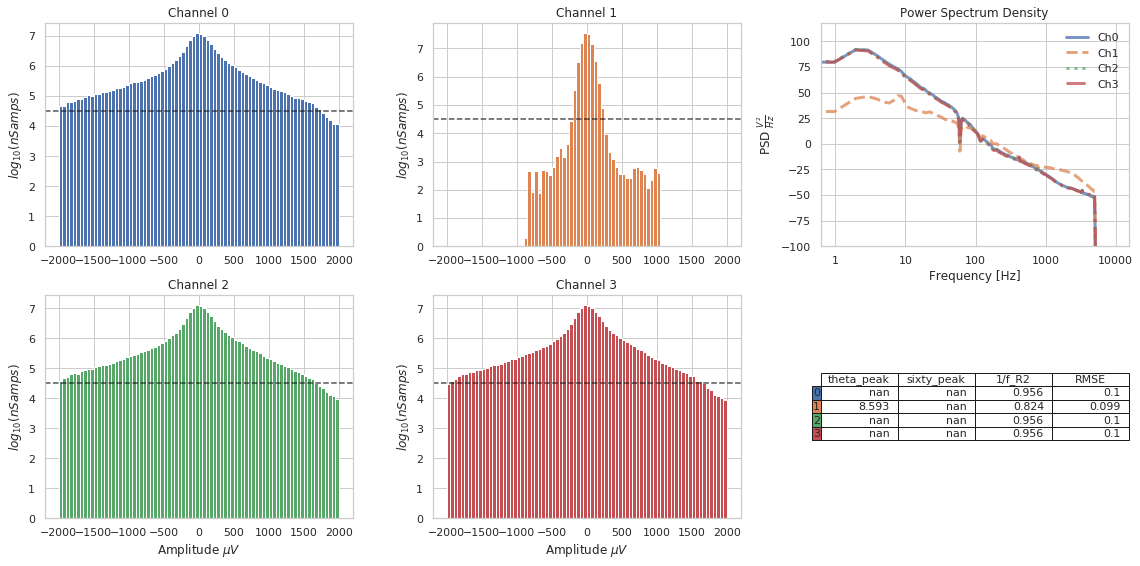

In [338]:
fig,ax = plt.subplots(2,3, figsize=(16,8))
ax= ax.flatten()
_=plotTTAmpsHists(hists,bins,ttInfo,ax[[0,1,3,4]])
ax[0].set_xlabel('')
ax[1].set_xlabel('')
_=plotTT_PSD_Table(freqs,pxx, df,ax[[2,5]])
fig.tight_layout(pad=1.0)

In [129]:
import spikeinterface.toolkit as st
??st.preprocessing.bandpass_filter
#??st.BandpassFilterRecording

Signature:
st.preprocessing.bandpass_filter(
    recording,
    freq_min=300,
    freq_max=6000,
    freq_wid=1000,
    type='fft',
    order=3,
    chunk_size=30000,
    cache_to_file=False,
    cache_chunks=False,
)
Source:   
def bandpass_filter(recording, freq_min=300, freq_max=6000, freq_wid=1000, type='fft', order=3,
                    chunk_size=30000, cache_to_file=False, cache_chunks=False):
    '''
    Performs a lazy filter on the recording extractor traces.

    Parameters
    ----------
    recording: RecordingExtractor
        The recording extractor to be filtered.
    freq_min: int or float
        High-pass cutoff frequency.
    freq_max: int or float
        Low-pass cutoff frequency.
    freq_wid: int or float
        Width of the filter (when type is 'fft').
    type: str
        'fft' or 'butter'. The 'fft' filter uses a kernel in the frequency domain. The 'butter' filter uses
        scipy butter and filtfilt functions.
    order: int
        Order of the filter 